# Black Box Data Analysis

Since the advent of IoT devices a lot of data has been available to companies in many businesses. In this project I will focus on cars' black boxes' data that is sent daily to an insurance company: these data contains information about daily distances traveled by clients, split by type of road traveled (i.e. higways, city streets...).

My main goal is to find a way of clustering clients based on the way they use the car by means of these daily distances: this type of analysis may have value in supporting the insurance company in the detection of riskier clients' behaviours and in the determination of premium amounts.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Data Ingestion

For this analysis I have data about each black box daily distances, saved in monthly csv files.

This notebook will focus on a subset of 10000 clients in order to outline the whole analysis, which will be done both using my local machine than cloud resources in order to accomodate the great amount of data.

As a first step I gather the data by looping through each file to read the daily data of a subset of the clients.

In [2]:
policies = pd.read_csv('./data/raw/policies.csv', sep=';')
voucher_list = np.random.choice(policies['n_voucher'].unique(), size=10000, replace=False)

In [3]:
def load_voucher_data(voucher_list, dir_string, filename_start):
    '''
    reads data for one or more vouchers passed in a list
    '''
    from pandas import DataFrame, read_csv, to_datetime
    from os import fsdecode, fsencode, path, listdir
    
    vou = DataFrame(columns=['n_voucher', 'n_policy', 'start_date', 'n_trips', 'km_day'])
    directory = fsencode(dir_string)

    # read all csv files for provider OCTO
    for file in listdir(directory):
        filename = fsdecode(file)
        if filename.endswith('.csv') and filename.startswith(filename_start):
            csv_file = path.join(dir_string, filename)
            print(csv_file)
            trips_temp = read_csv(csv_file, sep=';')
            if voucher_list == []:
                vou = vou.append(trips_temp[['n_voucher', 'n_policy', 'start_date', 'n_trips', 'km_day']])
            else:
                vou = vou.append(trips_temp.loc[trips_temp['n_voucher'].isin(voucher_list), ['n_voucher', 'n_policy', 'start_date', 'n_trips', 'km_day']])

    vou.sort_values(by=['n_voucher', 'start_date'], inplace=True)
    vou.reset_index(inplace=True)

    vou.drop('index', axis=1, inplace=True)
    vou['start_date'] = to_datetime(vou['start_date'])
    vou['dow'] = vou['start_date'].dt.weekday
    vou['year'] = vou['start_date'].dt.year
    vou['doy'] = vou['start_date'].dt.dayofyear

    return vou

In [5]:
vou = load_voucher_data(voucher_list, r'.\data\raw', 'OCTO_')

.\data\raw\OCTO_201404.csv


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


.\data\raw\OCTO_201405.csv
.\data\raw\OCTO_201406.csv
.\data\raw\OCTO_201407.csv
.\data\raw\OCTO_201408.csv
.\data\raw\OCTO_201409.csv
.\data\raw\OCTO_201410.csv
.\data\raw\OCTO_201411.csv
.\data\raw\OCTO_201412.csv
.\data\raw\OCTO_201501.csv
.\data\raw\OCTO_201502.csv
.\data\raw\OCTO_201503.csv
.\data\raw\OCTO_201504.csv
.\data\raw\OCTO_201505.csv
.\data\raw\OCTO_201506.csv
.\data\raw\OCTO_201507.csv
.\data\raw\OCTO_201508.csv
.\data\raw\OCTO_201509.csv
.\data\raw\OCTO_201510.csv
.\data\raw\OCTO_201511.csv
.\data\raw\OCTO_201512.csv
.\data\raw\OCTO_201601.csv
.\data\raw\OCTO_201602.csv
.\data\raw\OCTO_201603.csv
.\data\raw\OCTO_201604.csv
.\data\raw\OCTO_201605.csv
.\data\raw\OCTO_201606.csv
.\data\raw\OCTO_201607.csv
.\data\raw\OCTO_201608.csv
.\data\raw\OCTO_201609.csv
.\data\raw\OCTO_201610.csv
.\data\raw\OCTO_201611.csv
.\data\raw\OCTO_201612.csv
.\data\raw\OCTO_201701.csv
.\data\raw\OCTO_201702.csv
.\data\raw\OCTO_201703.csv
.\data\raw\OCTO_201704.csv
.\data\raw\OCTO_201705.csv
.

In [6]:
vou.head()

,n_voucher,n_policy,start_date,n_trips,km_day,dow,year,doy
0,2189826,100012049931,2014-04-01 06:00:05,4,37.489,1,2014,91
1,2189826,100012049931,2014-04-02 05:57:47,4,36.343,2,2014,92
2,2189826,100012049931,2014-04-03 05:59:25,4,31.905,3,2014,93
3,2189826,100012049931,2014-04-04 05:57:20,3,31.966,4,2014,94
4,2189826,100012049931,2014-04-05 10:55:46,3,24.576,5,2014,95


In [7]:
vou.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8908206 entries, 0 to 8908205
Data columns (total 8 columns):
n_voucher     object
n_policy      object
start_date    datetime64[ns]
n_trips       object
km_day        float64
dow           int64
year          int64
doy           int64
dtypes: datetime64[ns](1), float64(1), int64(3), object(3)
memory usage: 543.7+ MB


In [4]:
# vou.to_pickle('./data/interim/vou10000.pkl')
vou = pd.read_pickle('./data/interim/vou10000.pkl')

## Data Cleaning

The data contains daily information for each black box, but each black box can cover many years of insurance for a given client: in order to analyze the data from a common perspective I will treat each insurance annuality separately, and to do so I'm adding the annuality joining the insurance policy data.

Since the black box is installed by a third party, there is not always a correspondence between the daily data and the insurance policy coverage; this means that I have to check whether the daily distances' dates are included in the insurance annuality. Moreover, I will drop the annualities for which I have less than 100 days of data.

In [5]:
vou = vou.merge(policies[['n_policy', 'n_voucher', 'client_status', 'annuality_start_date']], left_on=['n_policy', 'n_voucher'], right_on=['n_policy', 'n_voucher'], how='left')

In [6]:
vou['annuality_start_date'] = pd.to_datetime(vou['annuality_start_date'])
vou['annuality'] = vou['annuality_start_date'].dt.year

In [7]:
temp = vou.loc[(vou['start_date']>=vou['annuality_start_date']) & (vou['start_date']<=(vou['annuality_start_date'] + pd.to_timedelta(1, unit='y') + pd.to_timedelta(18, unit='h') + pd.to_timedelta(10, unit='m')))].copy()
temp.reset_index(inplace=True)
vou = temp

Let's also check if there are missing days in the data:

In [8]:
vou['date'] = vou['start_date'].shift(1).dt.date
vou['check_date'] = vou['start_date'].dt.date + pd.to_timedelta(-1, unit='d')
vou['check_voucher'] = vou['n_voucher'].shift(1)
vou['check_annuality'] = vou['annuality'].shift(1)

In [9]:
missing = vou.loc[(vou['date']!=vou['check_date']) & (vou['n_voucher']==vou['check_voucher']) & (vou['annuality']==vou['check_annuality'])]

In [10]:
vou = vou.merge(missing.groupby(['n_voucher', 'annuality'])['start_date'].max().reset_index(),
              left_on=['n_voucher', 'annuality'],
              right_on=['n_voucher', 'annuality'], how='left')\
        .rename(columns={'start_date_x':'start_date', 'start_date_y':'to_date'})

In [11]:
vou['to_drop'] = vou['start_date'] < vou['to_date']
vou.drop(vou.loc[vou['to_drop']].index, inplace=True)
vou.reset_index(inplace=True)
vou.drop(['date', 'check_date', 'check_voucher', 'check_annuality', 'to_date', 'to_drop', 'level_0', 'index'], axis=1, inplace=True)

Finally let's drop the annualities with less than 100 days of data:

In [12]:
voucher_few_days = vou.groupby(['n_voucher', 'annuality'])['km_day'].count().loc[(vou.groupby(['n_voucher', 'annuality'])['km_day'].count() < 100)].index.values

In [13]:
vou = vou.set_index(['n_voucher', 'annuality']).drop(voucher_few_days, axis=0)
vou.reset_index(inplace=True)

It turns out I have also annualities with more than 365/366 days: this is due to bad data, namely clients with multiple policies in a year that were not treated correctly. I will cleanse this data manually after identifying the bad data.

In [14]:
vou.groupby(['n_voucher', 'annuality'])['km_day'].count().loc[(vou.groupby(['n_voucher', 'annuality'])['km_day'].count() > 366)]

n_voucher  annuality
2498676    2015         538
2630133    2014         465
2762033    2014         467
2838743    2015         392
2975989    2016         370
3004508    2016         523
3222997    2016         433
3465062    2015         692
3677761    2016         629
3801895    2016         400
4654786    2014         383
6638894    2016         460
7499793    2016         711
Name: km_day, dtype: int64

In [15]:
voucher_many_days = vou.groupby(['n_voucher', 'annuality'])['km_day'].count().loc[(vou.groupby(['n_voucher', 'annuality'])['km_day'].count() > 366)].index.values

In [16]:
vou.set_index(['n_voucher', 'annuality']).loc[voucher_many_days].reset_index().groupby(['n_voucher', 'annuality', 'n_policy'])['km_day'].count()

n_voucher  annuality  n_policy    
2498676    2015       104011243952    172
                      104011309194    343
                      104011449245     23
2630133    2014       104011128242     99
                      104011152449     81
                      104011168562     74
                      104011192709    211
2762033    2014       112015402765    101
                      112015404263    366
2838743    2015       104011199099     26
                      104011208698    366
2975989    2016       104011378648      5
                      104011379028    365
3004508    2016       104011385608    158
                      104011451646    365
3222997    2016       104011407529     68
                      104011429419    365
3465062    2015       104011188363    326
                      104011308937    366
3677761    2016       754015803378    263
                      754015820353    366
3801895    2016       734015168085     35
                      734015168282    365

In [17]:
vou_to_drop = [
(2498676,2015,104011243952), 
(2498676,2015,104011449245), 
(2630133,2014,104011128242), 
(2630133,2014,104011152449), 
(2630133,2014,104011168562), 
(2762033,2014,112015402765), 
(2838743,2015,104011199099), 
(2975989,2016,104011378648), 
(3004508,2016,104011385608), 
(3222997,2016,104011407529), 
(3465062,2015,104011188363), 
(3677761,2016,754015803378), 
(3801895,2016,734015168085), 
(4654786,2014,104011169105), 
(6638894,2016,104011379740), 
(7499793,2016,104011319956)   
]

In [18]:
vou = vou.set_index(['n_voucher', 'annuality', 'n_policy']).drop(vou_to_drop, axis=0)

In [19]:
vou.reset_index(inplace=True)

## EDA

I have a few different ways to analyze daily distances:

- bin the data using fixed cuts or quantiles and extract events' patterns using apriori
- use apriori as above but considering the day of the week in the patterns

#### Arbitrary Ranges

In [20]:
vou['km_bin'] = pd.cut(vou['km_day'], bins=[-1, 0, 10, 20, 30, 40, 50, 60, 100, 200, 300, 100000], labels=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K'])

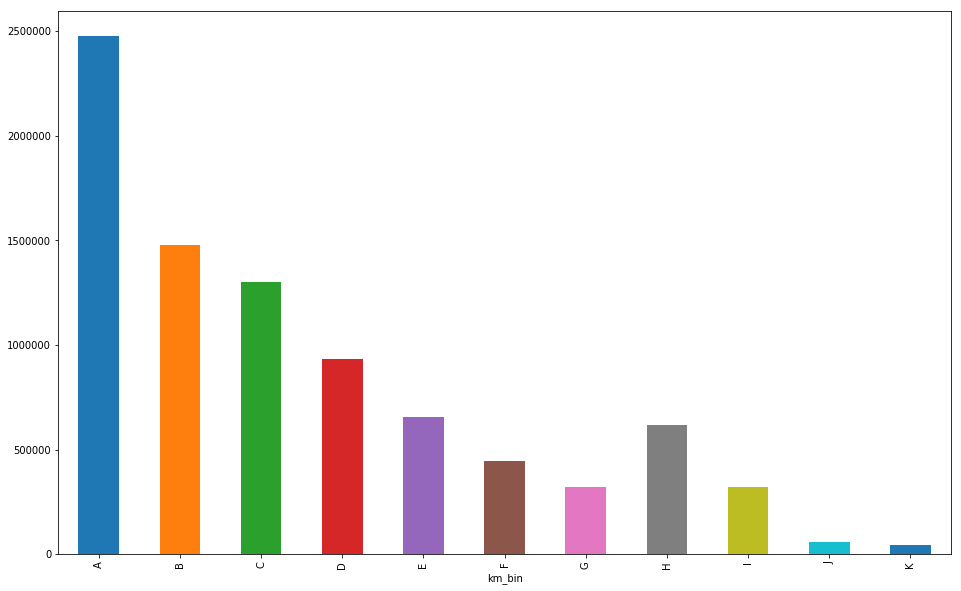

In [21]:
vou.groupby('km_bin')['km_day'].count().plot.bar(figsize=(16, 10));

#### Quantiles' Ranges

In [22]:
vou['km_bin_quant'] = pd.qcut(vou['km_day'], q=[0, .29, .5, .6, .7, .8, .9, .95, .99, 1], labels=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I'])

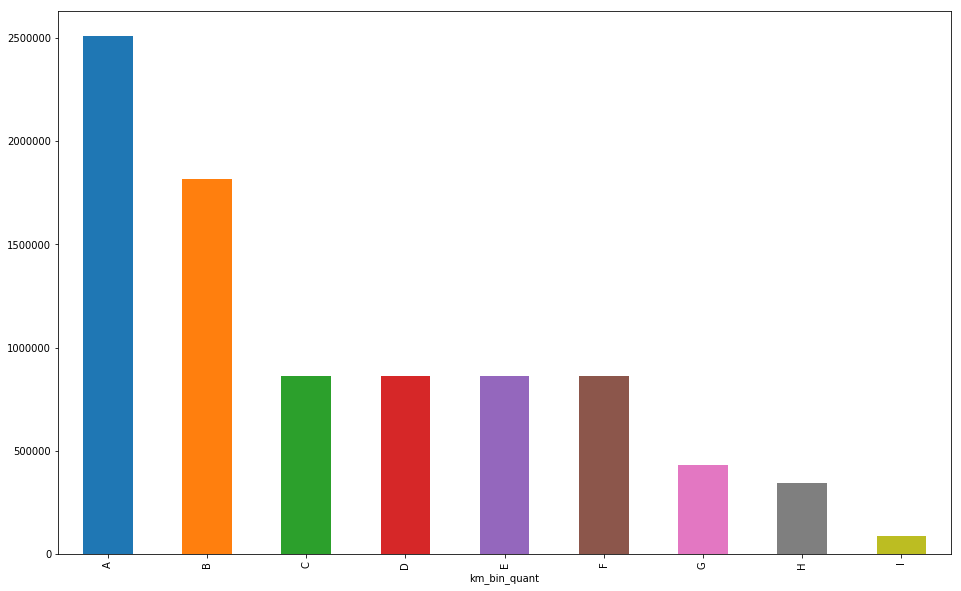

In [23]:
vou.groupby('km_bin_quant')['km_day'].count().plot.bar(figsize=(16, 10));

## Feature Extraction

Now I will create a dataframe containing a row per black box and annuality, adding the time series' decomposition's data, time series' data and all the binned distances to it.

In [24]:
vouchers = vou.groupby(['n_voucher', 'annuality']).agg({'km_day':['mean', 'median', 'std', 'min', 'max', 'count', 'sum']})
vouchers.columns = vouchers.columns.map('_'.join)
vouchers['km_day_quant25'] = vou.groupby(['n_voucher', 'annuality'])['km_day'].quantile(0.25)
vouchers['km_day_quant75'] = vou.groupby(['n_voucher', 'annuality'])['km_day'].quantile(0.75)
# zero km days
vouchers['km_day_zero_count'] = vou.groupby(['n_voucher', 'annuality']).apply(lambda x: x.loc[x['km_day'] == 0, 'km_day'].count())

In [26]:
vouchers = vouchers.join(vou.groupby(['n_voucher', 'annuality'])['km_bin'].agg(lambda x: ''.join(x.values)))
vouchers = vouchers.join(vou.groupby(['n_voucher', 'annuality'])['km_bin_quant'].agg(lambda x: ''.join(x.values)))

In [27]:
vouchers.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 26769 entries, (2189826, 2014) to (14032492, 2017)
Data columns (total 12 columns):
km_day_mean          26769 non-null float64
km_day_median        26769 non-null float64
km_day_std           26769 non-null float64
km_day_min           26769 non-null float64
km_day_max           26769 non-null float64
km_day_count         26769 non-null int64
km_day_sum           26769 non-null float64
km_day_quant25       26769 non-null float64
km_day_quant75       26769 non-null float64
km_day_zero_count    26769 non-null int64
km_bin               26769 non-null object
km_bin_quant         26769 non-null object
dtypes: float64(8), int64(2), object(2)
memory usage: 2.6+ MB


## Apriori

Now I'm going to use the apriori algorithm to find recurrent patterns for each client's insurance annuality. First I'll test the algorithm on a single annuality, then I'm going to use it on all the data.

In [29]:
vou_apriori = vouchers[['km_bin', 'km_bin_quant']].copy()

In [30]:
def apriori(eps, df, col):
    from collections import Counter
    from itertools import product
    freq = {}
    cnt = df[col].apply(lambda x: Counter(x))
    cnt = dict(cnt.sum())
    freq[1] = {k:v for k, v in cnt.items() if v >= eps}
    freq[0] = freq[1]
    for i in range(2, 8):
        freq[i] = {}
        for item in product(freq[i-1], freq[0]):
            key = ''.join(item)
            value = df[col].apply(lambda x: x.count(key)).sum()
            if value >= eps:
                freq[i][key] = value
        print(i, len(freq[i]))
    return freq

#### Arbitrary ranges

In [31]:
freq = apriori(20000, vou_apriori, 'km_bin')

2 79
3 65
4 31
5 14
6 9
7 7


In [32]:
vou_bin = vou_apriori.copy()

In [33]:
features = [list(freq[i].keys()) for i in range(3, 8)]
features = [item for sublist in features for item in sublist]

In [34]:
for f in features:
    vou_bin[f] = vou_bin['km_bin'].apply(lambda x: x.count(f))

In [35]:
vou_bin.drop(['km_bin', 'km_bin_quant'], axis=1, inplace=True)

#### Quantiles' ranges

In [36]:
freq_quant = apriori(20000, vou_apriori, 'km_bin_quant')

2 64
3 85
4 32
5 20
6 8
7 8


In [37]:
vou_quant = vou_apriori.copy()

In [38]:
features = [list(freq_quant[i].keys()) for i in range(3, 8)]
features = [item for sublist in features for item in sublist]

In [39]:
for f in features:
    vou_quant[f] = vou_quant['km_bin_quant'].apply(lambda x: x.count(f))

In [40]:
vou_quant.drop(['km_bin', 'km_bin_quant'], axis=1, inplace=True)

## Clustering

Now I'm going to use the patterns obtained with apriori in order to label the insurance annualities trying to capture the driving habits of the clients in this way.

In [41]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import StandardScaler

### tf-idf

First of all I'm applying tf-idf to normalize the data and weight less som very common patterns (e.g. the AAA pattern which translates to "not using the car for three days in a row").

In [42]:
tfidf = TfidfTransformer()
vou_apriori_sc = pd.DataFrame(tfidf.fit_transform(vou_bin.values).todense(), index=vou_bin.index, columns=vou_bin.columns)
vou_apriori_quant_sc = pd.DataFrame(tfidf.fit_transform(vou_quant.values).todense(), index=vou_quant.index, columns=vou_quant.columns)

#### Scaling

Regarding the series' data I'll scale it to have comparable units to the ones used for apriori features after tf-idf and I'll join this features to the apriori datasets.

In [45]:
vouchers.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 26769 entries, (2189826, 2014) to (14032492, 2017)
Data columns (total 12 columns):
km_day_mean          26769 non-null float64
km_day_median        26769 non-null float64
km_day_std           26769 non-null float64
km_day_min           26769 non-null float64
km_day_max           26769 non-null float64
km_day_count         26769 non-null int64
km_day_sum           26769 non-null float64
km_day_quant25       26769 non-null float64
km_day_quant75       26769 non-null float64
km_day_zero_count    26769 non-null int64
km_bin               26769 non-null object
km_bin_quant         26769 non-null object
dtypes: float64(8), int64(2), object(2)
memory usage: 2.6+ MB


In [47]:
sc = StandardScaler()
vouchers = pd.DataFrame(sc.fit_transform(vouchers.drop(['km_bin', 'km_bin_quant'], axis=1)),
                        index=vouchers.index,
                        columns=vouchers.drop(['km_bin', 'km_bin_quant'], axis=1).columns)

In [50]:
vou_apriori_all = vou_apriori_sc.copy()
vou_apriori_all = vou_apriori_all.join(vouchers)
vou_apriori_quant_all = vou_apriori_quant_sc.copy()
vou_apriori_quant_all = vou_apriori_quant_all.join(vouchers)

#### K-Means

Now I'll use K-Means to cluster the annualities:

In [51]:
km = KMeans()
km_quant = KMeans()
km_all = KMeans()
km_quant_all = KMeans()

In [52]:
inertia = []
inertia_quant = []
inertia_all = []
inertia_quant_all = []

for n in range(2, 21):
    km.set_params(n_clusters=n)
    km.fit(vou_apriori_sc)
    inertia.append(km.inertia_)
    
    km_quant.set_params(n_clusters=n)
    km_quant.fit(vou_apriori_quant_sc)
    inertia_quant.append(km_quant.inertia_)
    
    km_all.set_params(n_clusters=n)
    km_all.fit(vou_apriori_all)
    inertia_all.append(km_all.inertia_)
    
    km_quant_all.set_params(n_clusters=n)
    km_quant_all.fit(vou_apriori_quant_all)
    inertia_quant_all.append(km_quant_all.inertia_)

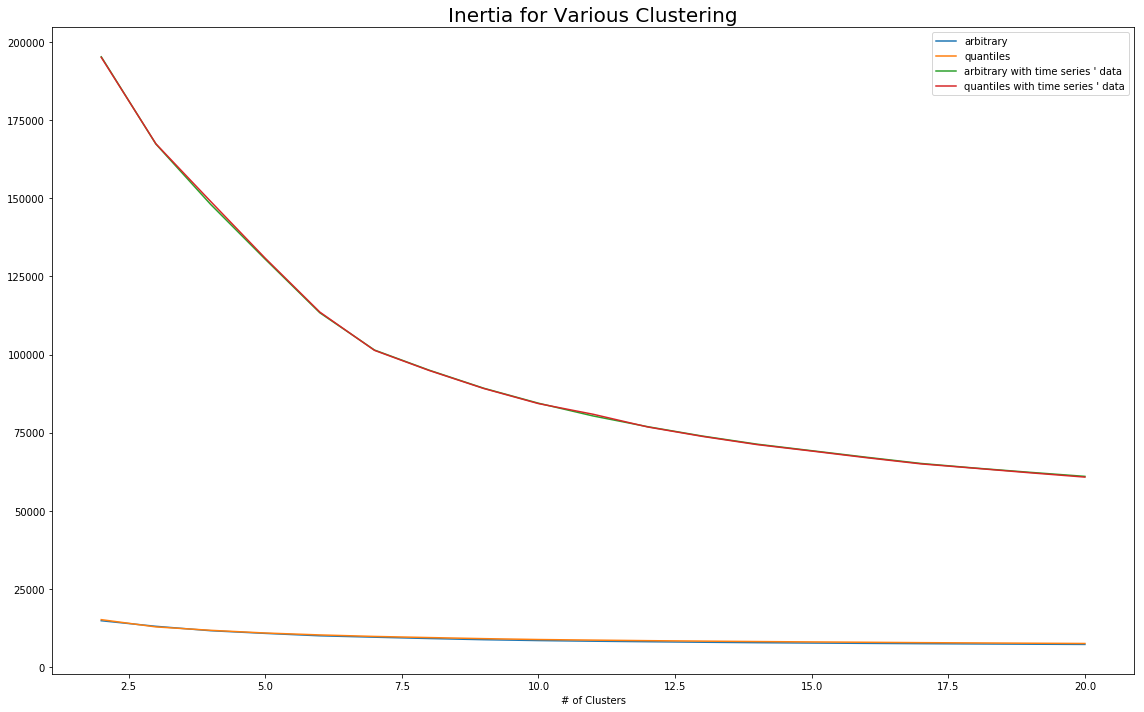

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(16, 10))
ax.plot(range(2, 21), inertia, label='arbitrary')
ax.plot(range(2, 21), inertia_quant, label='quantiles')
ax.plot(range(2, 21), inertia_all, label='arbitrary with time series \' data')
ax.plot(range(2, 21), inertia_quant_all, label='quantiles with time series \' data')
ax.legend()
ax.set_title('Inertia for Various Clustering', fontsize=20)
ax.set_xlabel('# of Clusters')
fig.tight_layout();
# fig.savefig('./reports/figures/inertia.png');

Ten seems a good choice for the number of clusters:

In [56]:
km.set_params(n_clusters=10)
km.fit(vou_apriori_sc)
vou_apriori_sc['label'] = km.labels_

km_quant.set_params(n_clusters=10)
km_quant.fit(vou_apriori_quant_sc)
vou_apriori_quant_sc['label'] = km_quant.labels_

km_all.set_params(n_clusters=10)
km_all.fit(vou_apriori_all)
vou_apriori_all['label'] = km_all.labels_

km_quant_all.set_params(n_clusters=10)
km_quant_all.fit(vou_apriori_quant_all)
vou_apriori_quant_all['label'] = km_quant_all.labels_

## COR

Finally I'm going to measure how good the clustering is in terms of separating costly clients from the rest: to do this I'll use the COR, a way of measuring the ratio between premium collected and associated claims' cost.

In [57]:
premium = pd.read_csv('./data/raw/premium.csv', sep=';')
premium = premium.merge(vou.groupby(['n_voucher', 'n_policy'])['annuality'].min().reset_index(), how='inner', left_on=['n_voucher', 'n_policy'], right_on=['n_voucher', 'n_policy'])
premium = premium.groupby(['n_voucher', 'annuality'])['assistcb_premium', 'assistext_premium',
                                           'attievent_premium', 'collis_premium', 'cristalli_premium',
                                           'incfurto_premium', 'infortuni_premium', 'rca_premium',
                                           'tutleg_premium'].sum()

In [58]:
vou_apriori_sc = vou_apriori_sc.merge(premium, how='left', left_index=True, right_index=True)
vou_apriori_sc['premium'] = vou_apriori_sc['assistcb_premium'] + vou_apriori_sc['assistext_premium']\
                        + vou_apriori_sc['attievent_premium'] + vou_apriori_sc['collis_premium']\
                        + vou_apriori_sc['cristalli_premium'] + vou_apriori_sc['incfurto_premium']\
                        + vou_apriori_sc['infortuni_premium'] + vou_apriori_sc['rca_premium']\
                        + vou_apriori_sc['tutleg_premium']

vou_apriori_quant_sc = vou_apriori_quant_sc.merge(premium, how='left', left_index=True, right_index=True)
vou_apriori_quant_sc['premium'] = vou_apriori_quant_sc['assistcb_premium'] + vou_apriori_quant_sc['assistext_premium']\
                                + vou_apriori_quant_sc['attievent_premium'] + vou_apriori_quant_sc['collis_premium']\
                                + vou_apriori_quant_sc['cristalli_premium'] + vou_apriori_quant_sc['incfurto_premium']\
                                + vou_apriori_quant_sc['infortuni_premium'] + vou_apriori_quant_sc['rca_premium']\
                                + vou_apriori_quant_sc['tutleg_premium']

vou_apriori_all = vou_apriori_all.merge(premium, how='left', left_index=True, right_index=True)
vou_apriori_all['premium'] = vou_apriori_all['assistcb_premium'] + vou_apriori_all['assistext_premium']\
                            + vou_apriori_all['attievent_premium'] + vou_apriori_all['collis_premium']\
                            + vou_apriori_all['cristalli_premium'] + vou_apriori_all['incfurto_premium']\
                            + vou_apriori_all['infortuni_premium'] + vou_apriori_all['rca_premium']\
                            + vou_apriori_all['tutleg_premium']

vou_apriori_quant_all = vou_apriori_quant_all.merge(premium, how='left', left_index=True, right_index=True)
vou_apriori_quant_all['premium'] = vou_apriori_quant_all['assistcb_premium'] + vou_apriori_quant_all['assistext_premium']\
                                + vou_apriori_quant_all['attievent_premium'] + vou_apriori_quant_all['collis_premium']\
                                + vou_apriori_quant_all['cristalli_premium'] + vou_apriori_quant_all['incfurto_premium']\
                                + vou_apriori_quant_all['infortuni_premium'] + vou_apriori_quant_all['rca_premium']\
                                + vou_apriori_quant_all['tutleg_premium']

In [59]:
claims = pd.read_csv('./data/raw/claims.csv', sep=';')
voucher_claims = claims.loc[claims['n_voucher'].isin(vou_apriori.index.get_level_values(0))].copy()
voucher_claims['year'] = pd.to_datetime(voucher_claims['accident_date']).dt.year
voucher_claims['claim_cost'] = voucher_claims['claim_paid_amount'] + voucher_claims['claim_provision_amount'] + voucher_claims['claim_paid_expenses'] + voucher_claims['claim_provision_expenses']
# capping claim cost over 20000€
voucher_claims['claim_cost'] = voucher_claims['claim_cost'].clip_upper(20000)

In [61]:
vou_apriori_sc['n_claims'] = voucher_claims.groupby(['n_voucher', 'year'])['n_claim'].count()
vou_apriori_sc['n_claims'] = vou_apriori_sc['n_claims'].fillna(0)
vou_apriori_sc['claims_cost'] = voucher_claims.groupby(['n_voucher', 'year'])['claim_cost'].sum()
vou_apriori_sc['claims_cost'] = vou_apriori_sc['claims_cost'].fillna(0)

vou_apriori_quant_sc['n_claims'] = voucher_claims.groupby(['n_voucher', 'year'])['n_claim'].count()
vou_apriori_quant_sc['n_claims'] = vou_apriori_quant_sc['n_claims'].fillna(0)
vou_apriori_quant_sc['claims_cost'] = voucher_claims.groupby(['n_voucher', 'year'])['claim_cost'].sum()
vou_apriori_quant_sc['claims_cost'] = vou_apriori_quant_sc['claims_cost'].fillna(0)

vou_apriori_all['n_claims'] = voucher_claims.groupby(['n_voucher', 'year'])['n_claim'].count()
vou_apriori_all['n_claims'] = vou_apriori_all['n_claims'].fillna(0)
vou_apriori_all['claims_cost'] = voucher_claims.groupby(['n_voucher', 'year'])['claim_cost'].sum()
vou_apriori_all['claims_cost'] = vou_apriori_all['claims_cost'].fillna(0)

vou_apriori_quant_all['n_claims'] = voucher_claims.groupby(['n_voucher', 'year'])['n_claim'].count()
vou_apriori_quant_all['n_claims'] = vou_apriori_quant_all['n_claims'].fillna(0)
vou_apriori_quant_all['claims_cost'] = voucher_claims.groupby(['n_voucher', 'year'])['claim_cost'].sum()
vou_apriori_quant_all['claims_cost'] = vou_apriori_quant_all['claims_cost'].fillna(0)

#### Plots

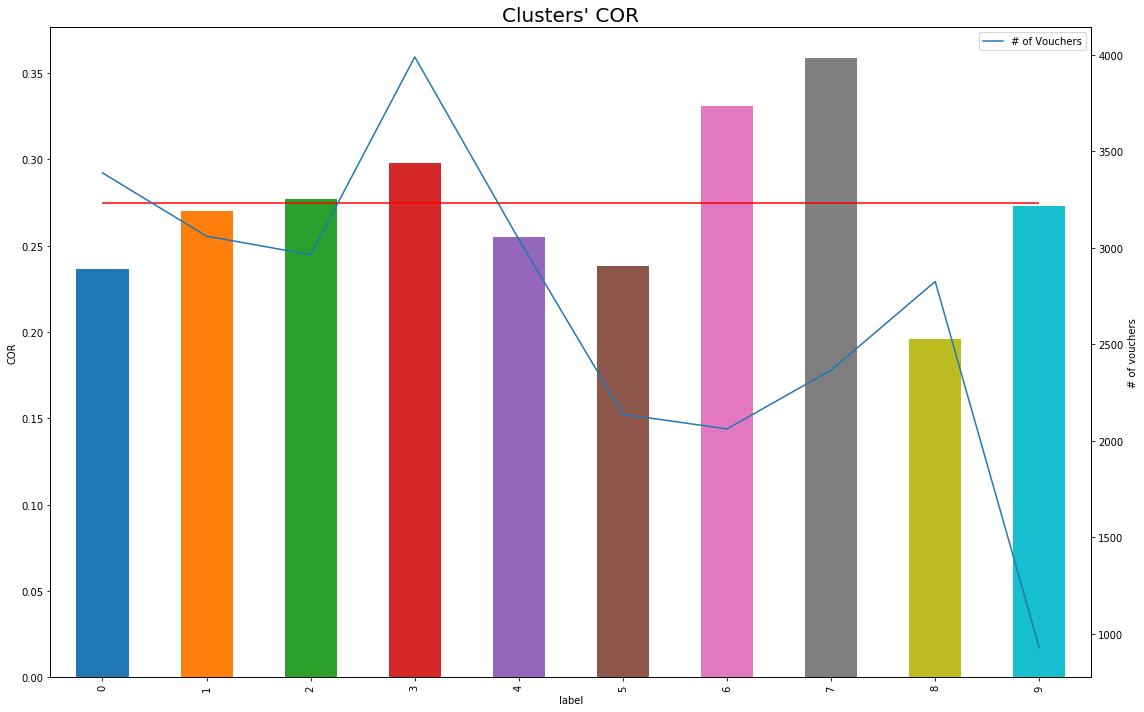

In [62]:
fig, ax = plt.subplots(figsize=(16, 10))
(vou_apriori_sc.groupby('label')['claims_cost'].sum() / vou_apriori_sc.groupby('label')['premium'].sum()).plot(kind='bar', ax=ax, label = '')
ax.hlines(vou_apriori_sc['claims_cost'].sum() / vou_apriori_sc['premium'].sum(), 0, 9, colors='r', label='Mean COR')
ax.set_ylabel('COR')
ax.set_title('Clusters\' COR', fontsize=20)

ax2 = ax.twinx()
ax2.set_ylabel('# of vouchers')
(vou_apriori_sc.groupby('label')['n_claims'].count()).plot(kind='line', ax=ax2, label='# of Vouchers')
ax2.legend()

fig.tight_layout();

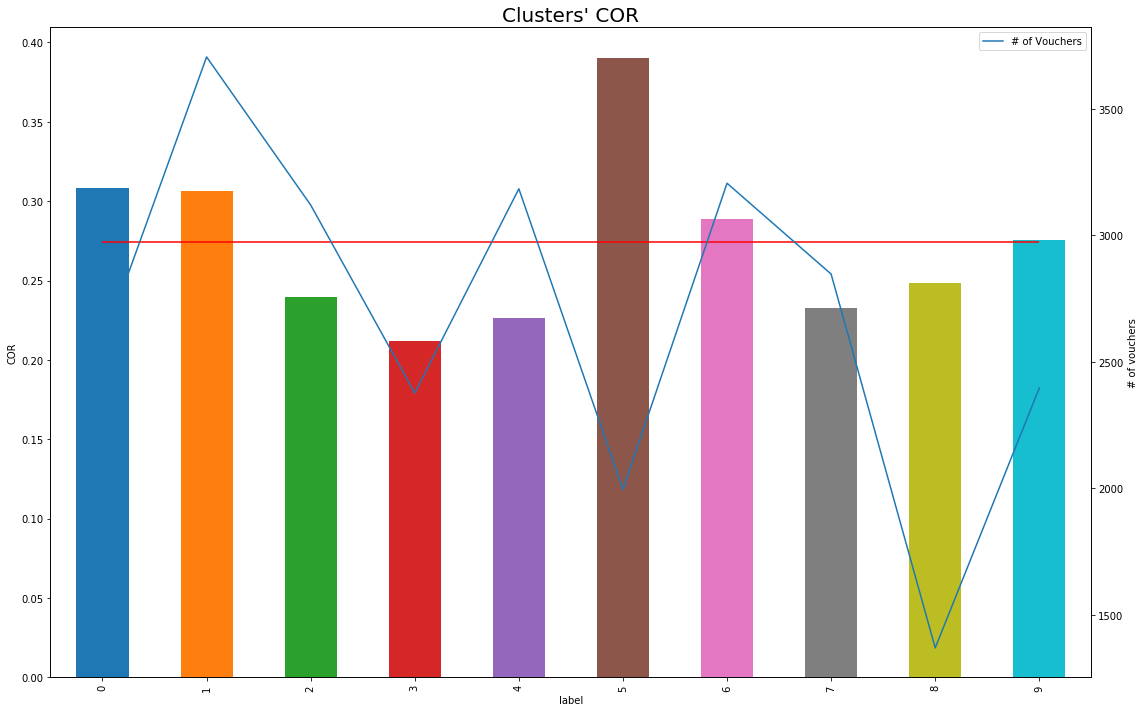

In [63]:
fig, ax = plt.subplots(figsize=(16, 10))
(vou_apriori_quant_sc.groupby('label')['claims_cost'].sum() / vou_apriori_quant_sc.groupby('label')['premium'].sum()).plot(kind='bar', ax=ax, label = '')
ax.hlines(vou_apriori_quant_sc['claims_cost'].sum() / vou_apriori_quant_sc['premium'].sum(), 0, 9, colors='r', label='Mean COR')
ax.set_ylabel('COR')
ax.set_title('Clusters\' COR', fontsize=20)

ax2 = ax.twinx()
ax2.set_ylabel('# of vouchers')
(vou_apriori_quant_sc.groupby('label')['n_claims'].count()).plot(kind='line', ax=ax2, label='# of Vouchers')
ax2.legend()

fig.tight_layout();

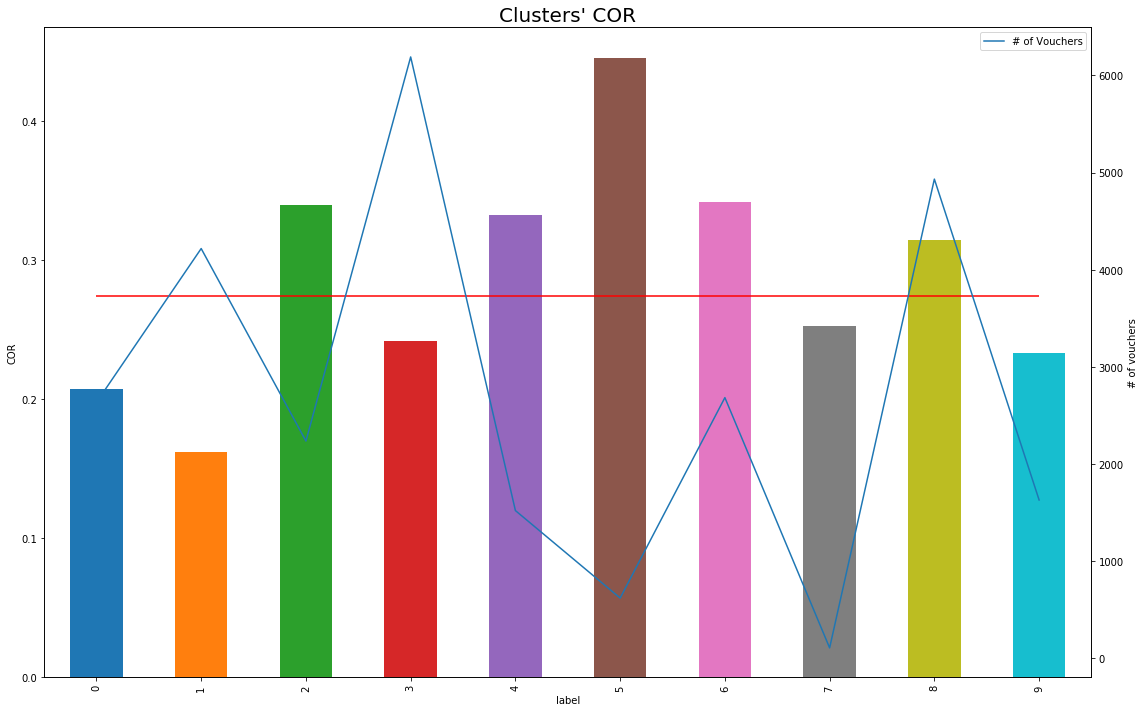

In [64]:
fig, ax = plt.subplots(figsize=(16, 10))
(vou_apriori_all.groupby('label')['claims_cost'].sum() / vou_apriori_all.groupby('label')['premium'].sum()).plot(kind='bar', ax=ax, label = '')
ax.hlines(vou_apriori_all['claims_cost'].sum() / vou_apriori_all['premium'].sum(), 0, 9, colors='r', label='Mean COR')
ax.set_ylabel('COR')
ax.set_title('Clusters\' COR', fontsize=20)

ax2 = ax.twinx()
ax2.set_ylabel('# of vouchers')
(vou_apriori_all.groupby('label')['n_claims'].count()).plot(kind='line', ax=ax2, label='# of Vouchers')
ax2.legend()

fig.tight_layout();

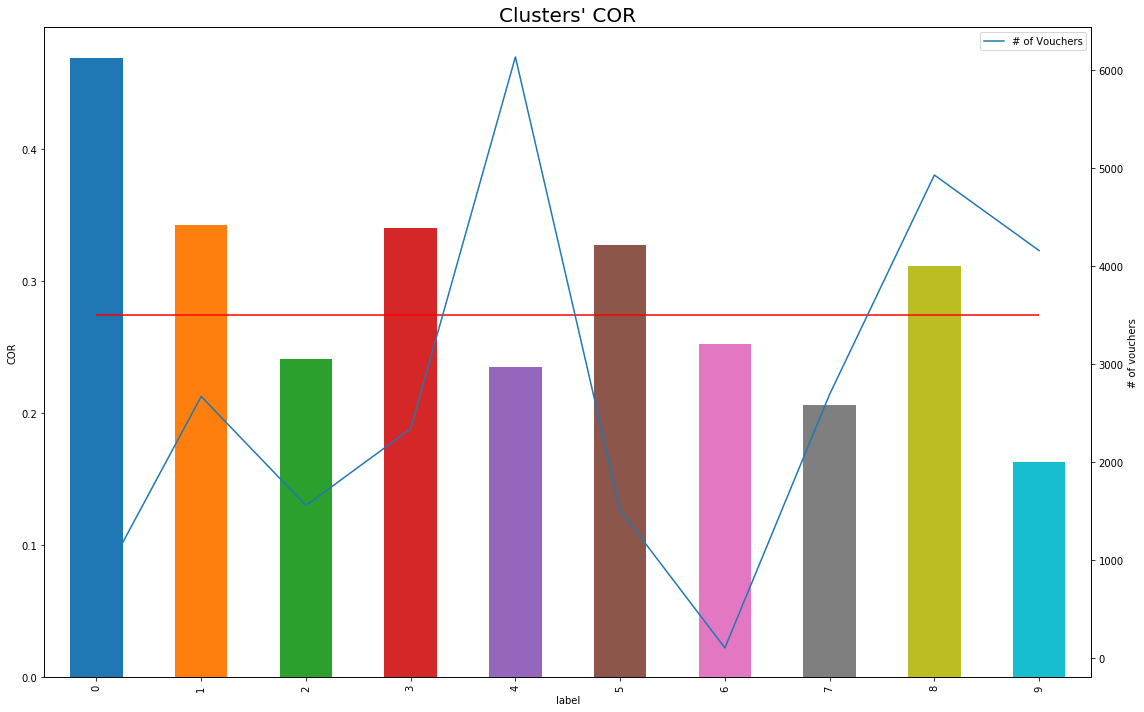

In [65]:
fig, ax = plt.subplots(figsize=(16, 10))
(vou_apriori_quant_all.groupby('label')['claims_cost'].sum() / vou_apriori_quant_all.groupby('label')['premium'].sum()).plot(kind='bar', ax=ax, label = '')
ax.hlines(vou_apriori_quant_all['claims_cost'].sum() / vou_apriori_quant_all['premium'].sum(), 0, 9, colors='r', label='Mean COR')
ax.set_ylabel('COR')
ax.set_title('Clusters\' COR', fontsize=20)

ax2 = ax.twinx()
ax2.set_ylabel('# of vouchers')
(vou_apriori_quant_all.groupby('label')['n_claims'].count()).plot(kind='line', ax=ax2, label='# of Vouchers')
ax2.legend()

fig.tight_layout();